### Getting reruired libraries

In [59]:
import os
import sys
import tarfile
from tqdm import tqdm
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from mltu.configs import BaseModelConfigs
from PIL import Image
import cv2
import typing
import numpy as np
from mltu.inferenceModel import OnnxInferenceModel
from mltu.utils.text_utils import ctc_decoder, get_cer
import pandas as pd
from tqdm import tqdm
from mltu.configs import BaseModelConfigs
from mltu.tensorflow.dataProvider import DataProvider
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CWERMetric
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from mltu.tensorflow.model_utils import residual_block
import seaborn as sns
from keras.models import load_model
import matplotlib.image as mpimg

### Dataset collection

In [2]:
def download_and_unzip(url, chunk_size=1024*1024):
    extract_to = os.path.join(os.getcwd(),'dataset')
    http_response = urlopen(url)

    data = b''
    iterations = http_response.length // chunk_size + 1
    for _ in tqdm(range(iterations)):
        data += http_response.read(chunk_size)

    zipfile = ZipFile(BytesIO(data))
    zipfile.extractall(path=extract_to)

dataset_path = os.path.join(os.path.join(os.getcwd(),'dataset'), 'IAM_Words') 
if not os.path.exists(dataset_path):
    download_and_unzip('https://git.io/J0fjL')

    file = tarfile.open(os.path.join(dataset_path, "words.tgz"))
    file.extractall(os.path.join(dataset_path, "words"))
    folder = os.path.join(dataset_path, "words")
    print('Sucessfully Extracted the dataset')

100%|██████████| 784/784 [05:59<00:00,  2.18it/s]


Sucessfully Extracted the dataset


### Dataset Description

In [3]:
dataset_folder_path = os.path.join(os.getcwd(),'dataset')
dataset_folder_path = os.path.join(dataset_folder_path,'IAM_Words')
data_desc_file_path = os.path.join(dataset_folder_path,'words.txt')
with open(data_desc_file_path,'r') as descr:
    description = descr.read()
    print(description)

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE
a01-000u-00-02 ok 154 796 764 70 50 TO to
a01-000u-00-03 ok 154 919 757 166 78 VB stop
a01-000u-00-04 ok 154 118

### Dataset Preprocessing

In [4]:
dataset, vocab, max_len = [], set(), 0
words = open(data_desc_file_path,'r').readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[1] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = line_split[0][:8]
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip('\n')

    rel_path = os.path.join(dataset_folder_path, "words", folder1, folder2, file_name)
    if not os.path.exists(rel_path):
        continue

    dataset.append([rel_path, label])
    vocab.update(list(label))
    max_len = max(max_len, len(label))

  0%|          | 0/115338 [00:00<?, ?it/s]

100%|██████████| 115338/115338 [00:30<00:00, 3788.49it/s] 


In [5]:
dataset

[['d:\\External_Projects\\ScriptVision_Advanced_Handwritten_Text_Recognition\\Aprroach_1\\dataset\\IAM_Words\\words\\a01\\a01-000u\\a01-000u-00-00.png',
  'A'],
 ['d:\\External_Projects\\ScriptVision_Advanced_Handwritten_Text_Recognition\\Aprroach_1\\dataset\\IAM_Words\\words\\a01\\a01-000u\\a01-000u-00-01.png',
  'MOVE'],
 ['d:\\External_Projects\\ScriptVision_Advanced_Handwritten_Text_Recognition\\Aprroach_1\\dataset\\IAM_Words\\words\\a01\\a01-000u\\a01-000u-00-02.png',
  'to'],
 ['d:\\External_Projects\\ScriptVision_Advanced_Handwritten_Text_Recognition\\Aprroach_1\\dataset\\IAM_Words\\words\\a01\\a01-000u\\a01-000u-00-03.png',
  'stop'],
 ['d:\\External_Projects\\ScriptVision_Advanced_Handwritten_Text_Recognition\\Aprroach_1\\dataset\\IAM_Words\\words\\a01\\a01-000u\\a01-000u-00-04.png',
  'Mr.'],
 ['d:\\External_Projects\\ScriptVision_Advanced_Handwritten_Text_Recognition\\Aprroach_1\\dataset\\IAM_Words\\words\\a01\\a01-000u\\a01-000u-00-05.png',
  'Gaitskell'],
 ['d:\\External_P

### Display Dataset

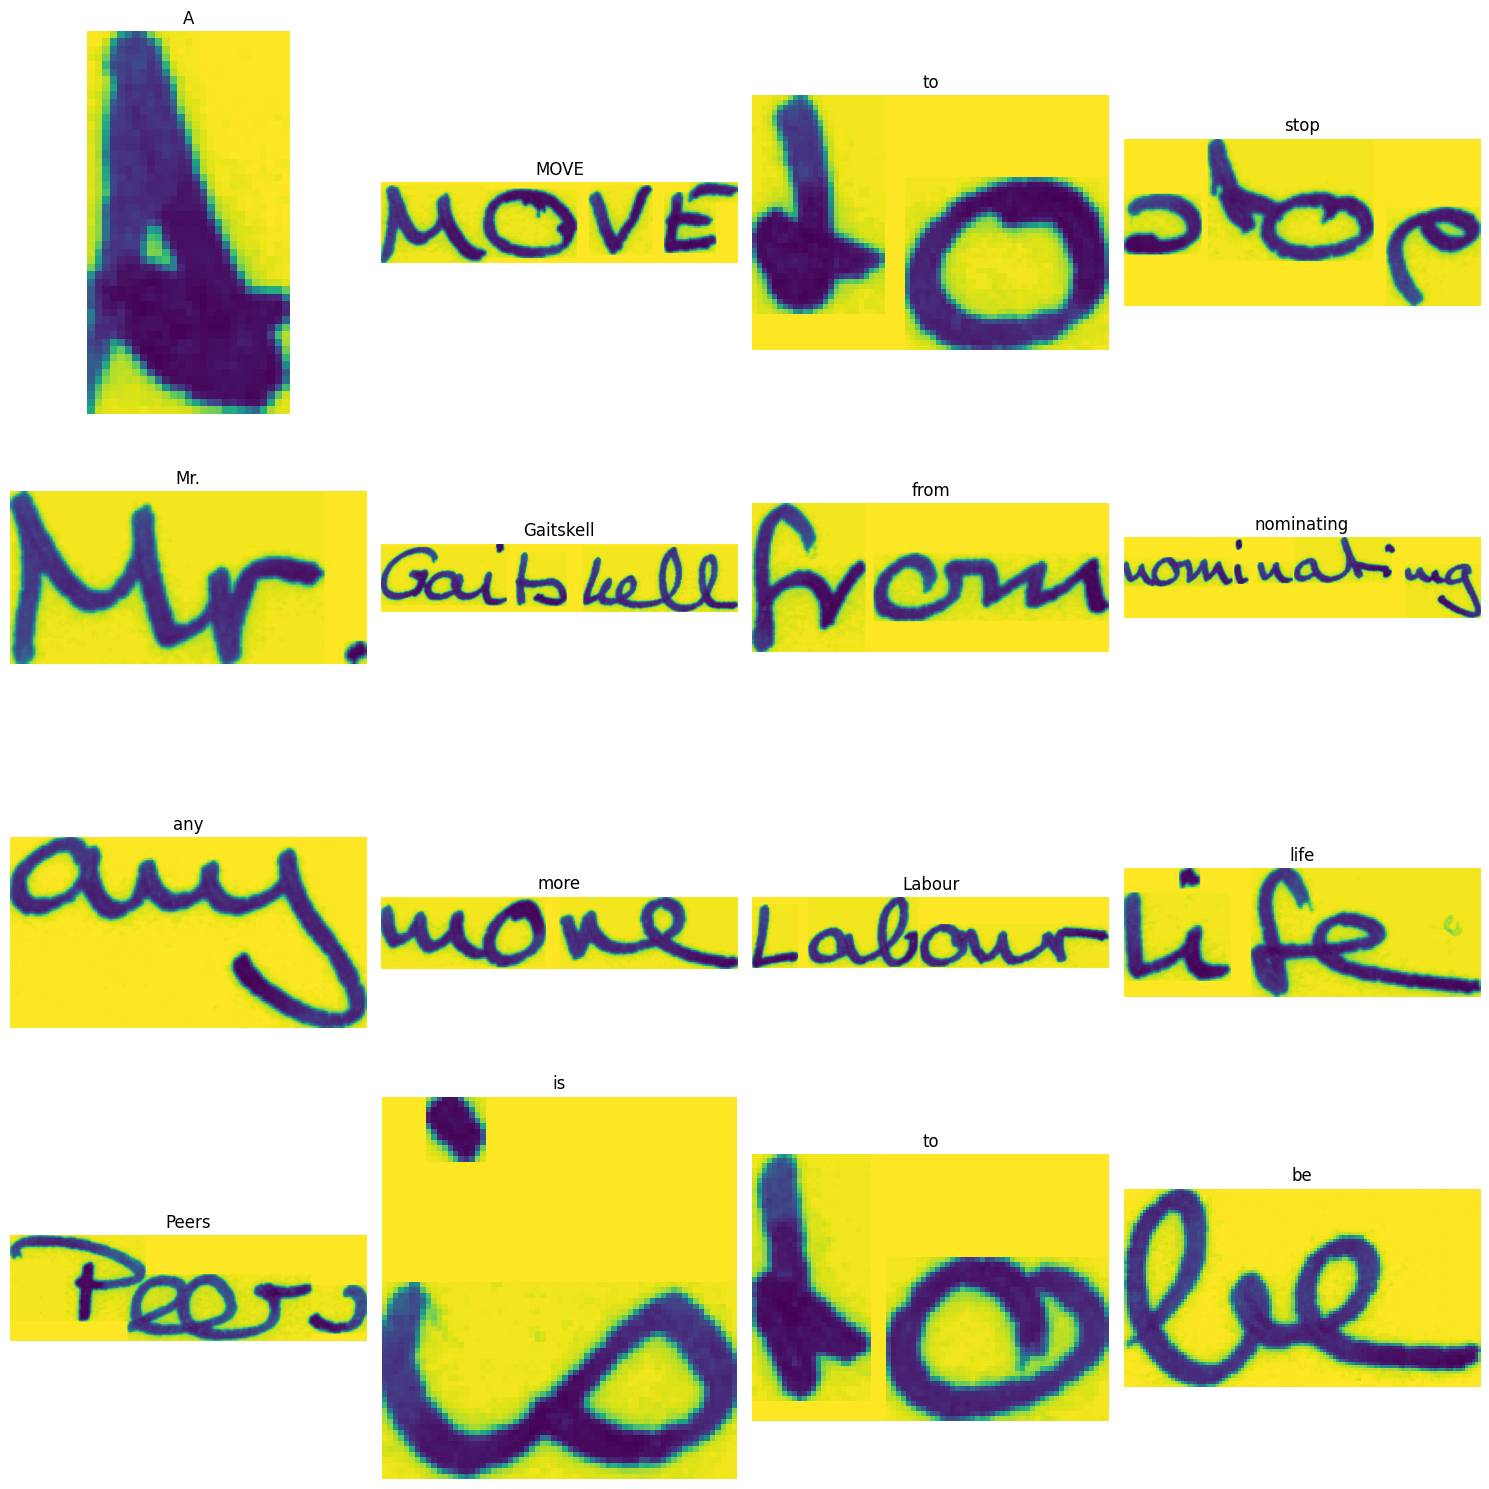

In [6]:
import matplotlib.pyplot as plt
import numpy as np

data = dataset

num_rows = 4
num_cols = 4
total_images = num_rows * num_cols

plt.figure(figsize=(15, 15))

for i, (image_path, label) in enumerate(data):
    if i >= total_images:
        break 

    image = plt.imread(image_path)
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off') 

plt.tight_layout()
plt.show()


### Model Configuration

In [7]:
class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.model_path = os.path.join("Models/03_handwriting_recognition", datetime.strftime(datetime.now(), "%Y%m%d%H%M"))
        self.vocab = ""
        self.height = 32
        self.width = 128
        self.max_text_length = 0
        self.batch_size = 16
        self.learning_rate = 0.0005
        self.train_epochs = 51
        self.train_workers = 20

### Saving model configuration

In [8]:
configs = ModelConfigs()
configs.vocab = "".join(vocab)
configs.max_text_length = max_len
configs.save()

### Data Provider

In [9]:
data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageResizer(configs.width, configs.height, keep_aspect_ratio=False),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
)

### Dataset Splitting in training and testing set

In [10]:
train_data_provider, val_data_provider = data_provider.split(split = 0.9)

### Data Augmentation

In [11]:
train_data_provider.augmentors = [
    RandomBrightness(), 
    RandomErodeDilate(),
    RandomSharpen(),
    RandomRotate(angle=10), 
    ]

### Model development

In [12]:
def train_model(input_dim, output_dim, activation="leaky_relu", dropout=0.2):
    
    inputs = layers.Input(shape=input_dim, name="input")

    input = layers.Lambda(lambda x: x / 255)(inputs)

    x1 = residual_block(input, 16, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x2 = residual_block(x1, 16, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x3 = residual_block(x2, 16, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x4 = residual_block(x3, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x5 = residual_block(x4, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x6 = residual_block(x5, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x7 = residual_block(x6, 64, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x8 = residual_block(x7, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)
    x9 = residual_block(x8, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    squeezed = layers.Reshape((x9.shape[-3] * x9.shape[-2], x9.shape[-1]))(x9)

    blstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(squeezed)
    blstm = layers.Dropout(dropout)(blstm)

    output = layers.Dense(output_dim + 1, activation="softmax", name="output")(blstm)

    model = Model(inputs=inputs, outputs=output)
    return model

In [13]:
model = train_model(
    input_dim = (configs.height, configs.width, 3),
    output_dim = len(configs.vocab),
)

d:\External_Projects\ScriptVision_Advanced_Handwritten_Text_Recognition\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate), 
    loss=CTCloss(), 
    metrics=[CWERMetric(padding_token=len(configs.vocab))],
)
model.summary(line_length=110)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape              ┃          Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)             │ (None, 32, 128, 3)        │                0 │ -                          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ lambda (Lambda)                │ (None, 32, 128, 3)        │                0 │ input[0][0]                │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d (Conv2D)                │ (None, 32, 128, 16)       │              448 │ lambda[0][0]               │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ batch_normalization            │ (None, 32, 128, 16)       │               64 │ conv2d[0][0]               │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)        │ (None, 32, 128, 16)       │                0 │ batch_normalization[0][0]  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)              │ (None, 32, 128, 16)       │            2,320 │ leaky_re_lu[0][0]          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ batch_normalization_1          │ (None, 32, 128, 16)       │               64 │ conv2d_1[0][0]             │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)              │ (None, 32, 128, 16)       │               64 │ lambda[0][0]               │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ add (Add)                      │ (None, 32, 128, 16)       │                0 │ batch_normalization_1[0][… │
│                                │                           │                  │ conv2d_2[0][0]             │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)      │ (None, 32, 128, 16)       │                0 │ add[0][0]                  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ dropout (Dropout)              │ (None, 32, 128, 16)       │                0 │ leaky_re_lu_1[0][0]        │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)              │ (None, 16, 64, 16)        │            2,320 │ dropout[0][0]              │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ batch_normalization_2          │ (None, 16, 64, 16)        │               64 │ conv2d_3[0][0]             │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)      │ (None, 16, 64, 16)        │                0 │ batch_normalization_2[0][… │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)              │ (None, 16, 64, 16)        │            2,320 │ leaky_re_lu_2[0][0]        │
├───

 Total params: 548,427 (2.09 MB)

 Trainable params: 546,955 (2.09 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [15]:
earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1,mode="min")
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=10, verbose=1, mode="auto")
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

In [ ]:
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx],
)

In [59]:
log_file_path = os.path.join(os.getcwd(),'Models','03_handwriting_recognition','202404271822','logs.log')

In [87]:
EPOCH = []
CER = []
WER = []
LOS = []
VAL_CER = []
VAL_WER = []
VAL_LOSS = []

with open(log_file_path, "r") as file:
    epoch = -4
    for line in file:
        line = line.split(';')
        if len(line[2:]) != 0:
            EPOCH.append(epoch)
            cer = line[1].split(':')[1]
            CER.append(cer)
            wer = line[2].split(':')[1]
            WER.append(cer)
            loss = line[3].split(':')[1]
            LOS.append(loss)
            val_cer = line[4].split(':')[1]
            VAL_CER.append(val_cer)
            val_wer = line[5].split(':')[1]
            VAL_WER.append(val_wer)
            val_loss = line[6].split(':')[1]
            VAL_LOSS.append(val_loss)
        epoch = epoch + 1

In [88]:
data = {
    "EPOCH" : EPOCH,
    "CER": CER,
    "WER": WER,
    "Loss": LOS,
    "Val_CER": VAL_CER,
    "Val_WER": VAL_WER,
    "Val_Loss": VAL_LOSS
}

df = pd.DataFrame(data)

### Performance Metrics

In [104]:
df.head()

EPOCH                  CER                  WER                 Loss  \
0      0   0.9778090119361877   0.9778090119361877   13.020298957824707   
1      1   0.9070425629615784   0.9070425629615784    11.75367259979248   
2      2   0.8499939441680908   0.8499939441680908   10.674738883972168   
3      3   0.8052283525466919   0.8052283525466919    9.922940254211426   
4      4   0.7703500986099243   0.7703500986099243    9.299188613891602   

               Val_CER              Val_WER               Val_Loss  
0   0.9717093110084534   0.9871924519538879    14.16010570526123\n  
1   0.9004657864570618   0.9620534777641296   11.830596923828125\n  
2   0.8450921773910522   0.9340274333953857    9.887504577636719\n  
3    0.803774356842041   0.9120703935623169   11.541232109069824\n  
4    0.766757071018219   0.8918885588645935    8.764852523803711\n

### Prediction 

In [19]:
test = dataset[:10]

In [20]:
test

[['d:\\External_Projects\\ScriptVision_Advanced_Handwritten_Text_Recognition\\Aprroach_1\\dataset\\IAM_Words\\words\\g06\\g06-018r\\g06-018r-06-02.png',
  'not'],
 ['d:\\External_Projects\\ScriptVision_Advanced_Handwritten_Text_Recognition\\Aprroach_1\\dataset\\IAM_Words\\words\\g06\\g06-018j\\g06-018j-08-01.png',
  'of'],
 ['d:\\External_Projects\\ScriptVision_Advanced_Handwritten_Text_Recognition\\Aprroach_1\\dataset\\IAM_Words\\words\\f07\\f07-076a\\f07-076a-08-03.png',
  'The'],
 ['d:\\External_Projects\\ScriptVision_Advanced_Handwritten_Text_Recognition\\Aprroach_1\\dataset\\IAM_Words\\words\\a01\\a01-020u\\a01-020u-07-03.png',
  'The'],
 ['d:\\External_Projects\\ScriptVision_Advanced_Handwritten_Text_Recognition\\Aprroach_1\\dataset\\IAM_Words\\words\\g06\\g06-031k\\g06-031k-02-03.png',
  'country'],
 ['d:\\External_Projects\\ScriptVision_Advanced_Handwritten_Text_Recognition\\Aprroach_1\\dataset\\IAM_Words\\words\\g06\\g06-026b\\g06-026b-00-03.png',
  'truly'],
 ['d:\\External_P

In [21]:
def add_padding(img, old_w, old_h, new_w, new_h):
    h1, h2 = int((new_h - old_h) / 2), int((new_h - old_h) / 2) + old_h
    w1, w2 = int((new_w - old_w) / 2), int((new_w - old_w) / 2) + old_w
    img_pad = np.ones([new_h, new_w, 3]) * 255
    img_pad[h1:h2, w1:w2, :] = img
    return img_pad


def fix_size(img, target_w, target_h):
    h, w = img.shape[:2]
    if w < target_w and h < target_h:
        img = add_padding(img, w, h, target_w, target_h)
    elif w >= target_w and h < target_h:
        new_w = target_w
        new_h = int(h * new_w / w)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    elif w < target_w and h >= target_h:
        new_h = target_h
        new_w = int(w * new_h / h)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    else:
        """w>=target_w and h>=target_h """
        ratio = max(w / target_w, h / target_h)
        new_w = max(min(target_w, int(w / ratio)), 1)
        new_h = max(min(target_h, int(h / ratio)), 1)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    return img


def preprocess(path, img_w, img_h):
    """ Pre-processing image for predicting """
    img = cv2.imread(path)
    img = fix_size(img, img_w, img_h)

    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = img.astype(np.float32)
    img /= 255
    return img

In [22]:
test_images_processed = []
original_test_texts = []
for d in test:
     temp_processed_image = preprocess(path=d[0], img_w=128, img_h=64)
     test_images_processed.append(temp_processed_image.T)
     original_test_texts.append(d[1])

In [25]:
test_images_processed = np.array(test_images_processed)
test_images_processed.shape

(10, 128, 64)

In [27]:
test_images_processed = test_images_processed.reshape(10, 128, 64, 1)
test_images_processed.shape

(10, 128, 64, 1)

of


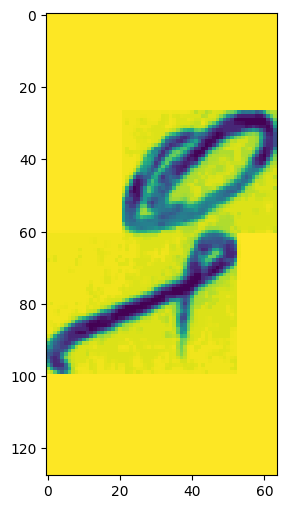

In [30]:
sns.reset_orig()
plt.figure(figsize=(3, 6))
i = 1
print(test[i][1])
plt.imshow(test_images_processed[i].reshape(128,64))

In [ ]:
new_model = tf.keras.models.load_model(r"D:\External_Projects\ScriptVision_Advanced_Handwritten_Text_Recognition\Aprroach_1\models\lstm-weights-epoch24-val_loss0.242.h5",compile=False)

In [54]:
text = []
directory = r"D:\External_Projects\ScriptVision_Advanced_Handwritten_Text_Recognition\sample_data_with_predicted_output"

for file in os.listdir(directory):
    if file.endswith('.jpg'):
        file_path = os.path.join(directory, file)
        img = preprocess(file_path)
        predicted_text = new_model.predict(img)
        text.append(predicted_text)

D:\External_Projects\ScriptVision_Advanced_Handwritten_Text_Recognition\sample_data_with_predicted_output\IMG-20240428-WA0002.jpg
D:\External_Projects\ScriptVision_Advanced_Handwritten_Text_Recognition\sample_data_with_predicted_output\IMG-20240428-WA0003.jpg
D:\External_Projects\ScriptVision_Advanced_Handwritten_Text_Recognition\sample_data_with_predicted_output\IMG-20240428-WA0004.jpg
D:\External_Projects\ScriptVision_Advanced_Handwritten_Text_Recognition\sample_data_with_predicted_output\IMG-20240428-WA0005.jpg


In [58]:
image_paths = []
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for file in os.listdir(directory):
    if file.endswith('.jpg'):
        file_path = os.path.join(directory, file)
        image_path.append(file_path)

In [57]:
directory = r"D:\External_Projects\ScriptVision_Advanced_Handwritten_Text_Recognition\sample_data_with_predicted_output"
output_file = os.path.join(os.getcwd(), "output.txt")
with open(output_file, "w") as f:
    for file in os.listdir(directory):
        if file.endswith('.jpg'):
            file_path = os.path.join(directory, file)
            f.write(file_path + "\n")
print("Done")

Done


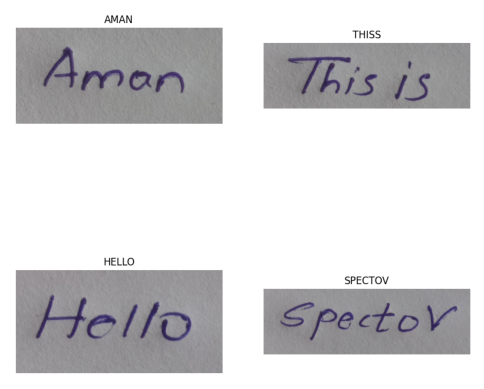

In [60]:
def display_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  #
    plt.show()
image_path = r"D:\External_Projects\ScriptVision_Advanced_Handwritten_Text_Recognition\sample_data_with_predicted_output\output.png"
display_image(image_path)